In [1]:
import numpy as np
import rasterio
from rasterio.features import shapes, geometry_mask
import rioxarray
from rioxarray.rioxarray import _add_attrs_proj
import json
import xarray as xr
import matplotlib.pyplot as plt

## Load original .tif image tile

In [2]:

dataPath = '/Users/maaikeizeboud/Documents/Data/test/'
imName = 'S2_comp_first.tif'
# labName = 'S2_20190131_-100p7_-75p0.geojson'
labName = 'output.geojson'



In [3]:
bands = rioxarray.open_rasterio(dataPath + imName)
bands.rio.bounds()

(-1653920.0, -366670.0, -1553880.0, -266650.0)

In [4]:
type(bands)

xarray.core.dataarray.DataArray

## Load labeldata 

labeldata.geojson contains both Polygon and MultiLine. 

NB: the labeldata is stored in EPSG:4325 projection,  (lat,lon) values.
This is converted to EPSG:3031 projection (Antarctic polarstereographic) BEFORE LOADING HERE. 
This has been done in terminal, not in this notebook, using GDAL's ogr2ogr: ``ogr2ogr   -s_srs EPSG:4326 -t_srs EPSG:3031  output.geojson   input.geojson``

In [5]:
with open(dataPath + labName) as f:
    gj = json.load(f)

features = gj['features'][0]['geometry'] # select one feature polygon for testing

len(gj['features'])
# gj

29

In [6]:
geometries=[];

# for feat in gj['features']:
#     coords = feat['geometry']['coordinates']
#     geometries.append(coords)
#     print(feat['geometry']['type']) # either Polygon or LineString type

# print(type(coords)) # a list.
# # print(geometries[-1])

# ## LIST WISE LOOP:
# shapes = [feat["geometry"] for feat in gj['features']]

### Convert poly to georegisterted polygon
Would rather skip this step, if we can get geometry_mask to work with 'features' geometry

ATTENTION: should test for MultiLine as well (now only Polygon)

In [7]:
from geopandas import GeoSeries
from shapely import geometry
from shapely.geometry import shape, mapping, MultiPolygon

    
# # poly1 = geometry.Polygon([[p.x,p.y] for p in plist1])
# poly = np.squeeze(features['coordinates']) # ndarray
# # poly1 = geometry.Polygon(poly)
# # polys = GeoSeries([poly1],crs=bands.spatial_ref.crs_wkt)

# ## Read multiple polygons/linestrings
# poly1 = geometry.LineString(np.squeeze(geometries[-1])) # squeeze is not necessary for LineString, but is for Polygon. So use for both.
# print(poly1)
# poly2 = geometry.Polygon(np.squeeze(geometries[0]))
# print(poly2)



# poly2 = geometry.Polygon(geometries[0])


In [8]:

geometries=[];

for feat in gj['features']:
    coords = feat['geometry']['coordinates']
#     geometries.append(coords)
    if feat['geometry']['type'] == 'LineString':
        poly = geometry.LineString(coords)
    if feat['geometry']['type'] == 'Polygon':
        poly = geometry.Polygon(np.squeeze(coords))
    geometries.append(poly)
print(type(coords)) # a list.
# print(geometries[-1])

<class 'list'>


In [9]:

# Combine
# polys = GeoSeries([poly1,poly2],crs=bands.spatial_ref.crs_wkt)
polys = GeoSeries(geometries,crs=bands.spatial_ref.crs_wkt) 


type(polys)

geopandas.geoseries.GeoSeries

## Create mask with rasterio.features.geometry_mask
### use georegistered polygon -- works
create mask based on geometry. Invert mask to select pixels WITHIN bounds. ATTENTION possible to select on touch or center inclusion

polys : dtype geometry / geopandas.geoseries.GeoSeries

Note: the mask consists of LineStrings & Polygons. The LineStrings are so small that they do not appear in the plotted mask, but they are there.

In [10]:
mmask = geometry_mask(polys,out_shape=(len(bands.y),len(bands.x)),transform=bands.rio.transform(),invert=True)

# Inspect data type of mask -> ndarray
mmask = np.expand_dims(mmask,axis=0)
mmask.shape

(1, 10002, 10004)

In [11]:
m2mask = mmask.astype(np.dtype('uint16'))
print(m2mask.min(),m2mask.max())
print(np.sum(m2mask > 0))


0 1
1038946


inspect mask

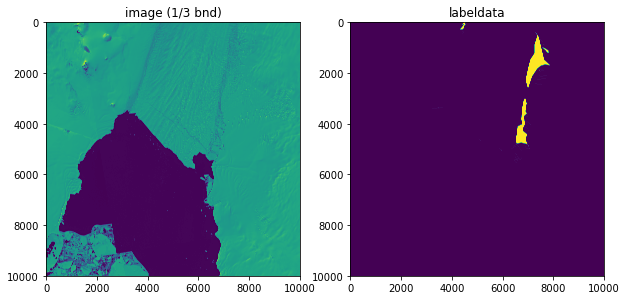

In [12]:

# imshow(amask[0])
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,10))
ax2.imshow(m2mask[0])
ax1.imshow(bands[0,:,:]) 
ax2.set_title('labeldata');
ax1.set_title('image (1/3 bnd)');

##### Try alternative rasterio masking:
- rasterio.features.rasterize
- rasterio.mask.mask

Results are the same for rasterio.features.geometry_mask. The lineString masking actually works, they are just not visible in the mask because they are so small wrt image size.

In [13]:

# ## LIST WISE LOOP:
# shapes = [feat["geometry"] for feat in gj['features']]
# shapes[4]['type']
# shapes = [ shapes[i] for i in range(4,9)] # select a few linestrings
# shapes

# testmask = rasterio.features.rasterize(shapes, 
#                             out_shape=(len(bands.y),len(bands.x)),
#                             transform=bands.rio.transform(), 
#                             all_touched=True )

In [14]:
# print(testmask.shape, testmask.min(),testmask.max())
# print(np.sum(testmask>0))
# # plt.figure(figsize=(15,15))
# plt.imshow(testmask)

In [15]:
# https://rasterio.readthedocs.io/en/latest/topics/masking-by-shapefile.html
# import rasterio.mask
# shapes = [ft["geometry"] for ft in gj['features']]
# with rasterio.open(dataPath + imName) as src:
#     out_image, out_transform = rasterio.mask.mask(src, shapes, crop=False)
#     out_meta = src.meta
# plt.imshow(np.moveaxis(out_image,0,-1))

### Convert Mask to integer and add as band to image
mask is boolean. Convert to integer representation true==1 false==0

convert mask to DataArray. import coordinates from bands

http://xarray.pydata.org/en/stable/api.html#dataarray

In [16]:

amask= xr.DataArray(data=m2mask,dims=['band','y','x'],coords={'band':[0],'y':bands[0].coords['y'],'x':bands[0].coords['x']})

In [17]:
data = amask
# np.any(np.isnan(data))
data.isnull().any()
# data.min()
# data.max()

<xarray.DataArray ()>
array(False)

In [18]:

_add_attrs_proj(amask,bands[0])

<xarray.DataArray (band: 1, y: 10002, x: 10004)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint16)
Coordinates:
  * band         (band) int64 0
  * y            (y) float64 -2.667e+05 -2.667e+05 ... -3.667e+05 -3.667e+05
  * x            (x) float64 -1.654e+06 -1.654e+06 ... -1.554e+06 -1.554e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     ('B4_first', 'B3_first', 'B2_first')
    grid_mapping:  spatial_ref

In [19]:
masked_image=xr.concat([bands,amask],'band')
masked_image

<xarray.DataArray (band: 4, y: 10002, x: 10004)>
array([[[ 9248,  9280,  9488, ...,  9232,  9232,  9344],
        [ 9336,  9480,  9392, ...,  9200,  9280,  9328],
        [ 9344,  9368,  9232, ...,  9240,  9320,  9296],
        ...,
        [  370,   361,   416, ...,  9624,  9640,  9584],
        [  386,   398,   365, ...,  9680,  9608,  9616],
        [  430,   347,   404, ...,  9624,  9632,  9632]],

       [[ 9880,  9896,  9984, ...,  9496,  9496,  9608],
        [ 9856,  9872,  9840, ...,  9440,  9504,  9616],
        [ 9784,  9784,  9768, ...,  9496,  9552,  9592],
        ...,
        [  461,   438,   506, ...,  9920,  9896,  9784],
        [  498,   472,   546, ...,  9920,  9856,  9816],
        [  512,   554,   478, ...,  9808,  9808,  9880]],

       [[10072, 10088, 10160, ...,  9584,  9696,  9704],
        [10016, 10104, 10048, ...,  9584,  9720,  9752],
        [ 9944,  9968,  9888, ...,  9664,  9808,  9752],
        ...,
        [  744,   735,   770, ...,  9992,  9904,  9800],
        [  776,   773,   814, ...,  9968,  9920,  9920],
        [  726,   785,   778, ...,  9872,  9880,  9992]],

       [[    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        ...,
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]]], dtype=uint16)
Coordinates:
  * band         (band) int64 1 2 3 0
  * y            (y) float64 -2.667e+05 -2.667e+05 ... -3.667e+05 -3.667e+05
  * x            (x) float64 -1.654e+06 -1.654e+06 ... -1.554e+06 -1.554e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     ('B4_first', 'B3_first', 'B2_first')
    grid_mapping:  spatial_ref

In [20]:
masked_image[-1,:,:] # select one layer

<xarray.DataArray (y: 10002, x: 10004)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)
Coordinates:
    band         int64 0
  * y            (y) float64 -2.667e+05 -2.667e+05 ... -3.667e+05 -3.667e+05
  * x            (x) float64 -1.654e+06 -1.654e+06 ... -1.554e+06 -1.554e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     ('B4_first', 'B3_first', 'B2_first')
    grid_mapping:  spatial_ref

### Check values

In [21]:
masked_image.isnull().any()

<xarray.DataArray ()>
array(False)
Coordinates:
    spatial_ref  int64 0

In [22]:
# masked_image.long_name
# select_vars()
# masked_image.__setitem__( ['long_name'],('B4_first', 'B3_first', 'B2_first'))

## Save masked image as .tif

In [25]:
source_data = dataPath + imName
outpath = dataPath + 'test_labelled_tile.tif'
outpath

'/Users/maaikeizeboud/Documents/Data/test/test_labelled_tile.tif'

In [26]:

with rasterio.open(source_data) as src:
    profile = src.profile
    profile.update(count=4) # add the new band to the profile

# uncomment to store output:

# with rasterio.open(outpath, 'w', **profile) as dst:
#     dst.write(masked_image)

